In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/Warm-ups/dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/Warm-ups'

In [82]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

In [83]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

In [84]:
batch_size = 60
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


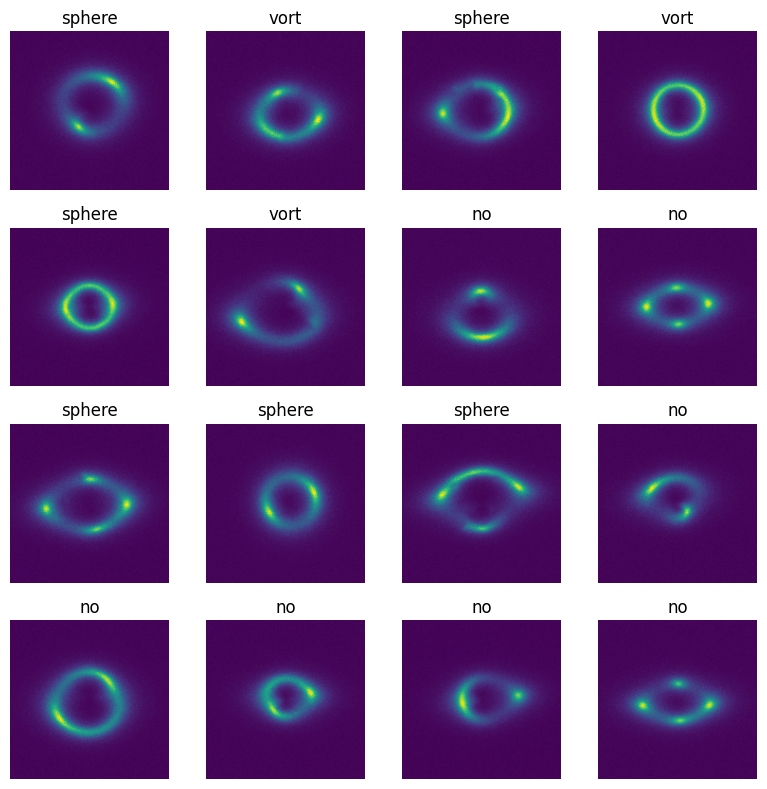

In [86]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [87]:
for batch in train_loader:
    print(batch[0].shape)
    break

torch.Size([60, 1, 150, 150])


In [88]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            preds = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            train_corrects += torch.sum(idx == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                preds = F.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, idx = torch.max(preds, 1)
                val_corrects += torch.sum(idx == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Step the scheduler
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '../best_param_ViT.pt')

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')

        model.load_state_dict(torch.load('../best_param_ViT.pt'))

    return model

In [59]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            total_corrects += torch.sum(idx == labels).item()

            y_pred_probs.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [95]:
# Initialize the Vision Transformer model
model = models.vit_b_16()
model.image_size = 150
model.num_classes = 3
model.seq_length = 82
model.hidden_dim = 256
model.mlp_dim = 1024
model.class_token = nn.Parameter(torch.zeros(1, 1, model.hidden_dim))
model.encoder.pos_embedding = nn.Parameter(torch.empty(1, model.seq_length, model.hidden_dim).normal_(std=0.02))

# Change from 3 to 1 channel
model.conv_proj = nn.Conv2d(1, 256, kernel_size=(16, 16), stride=(16, 16))

# Downsize the model
for layer in range(8):
    model.encoder.layers[layer].ln_1 = nn.LayerNorm((256,), eps=1e-06, elementwise_affine=True)
    model.encoder.layers[layer].self_attention.out_proj = nn.modules.linear.NonDynamicallyQuantizableLinear(256, 256, True)
    model.encoder.layers[layer].ln_2 = nn.LayerNorm((256,), eps=1e-06, elementwise_affine=True)
    model.encoder.layers[layer].mlp[0] = nn.Linear(256, 1024, True)
    model.encoder.layers[layer].mlp[3] = nn.Linear(1024, 256, True)

# Drop the last 3 encoder blocks
model.encoder.layers = model.encoder.layers[:-4]

model.encoder.ln = nn.LayerNorm((256,), eps=1e-06, elementwise_affine=True)
model.heads = nn.Linear(256, 3, True) # Adjust for 3 classes
model.to(device)

# Learning parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
criterion = nn.CrossEntropyLoss()

model

VisionTransformer(
  (conv_proj): Conv2d(1, 256, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=1024, out_features=256, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (self_a

In [96]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
print('Finished')

AssertionError: was expecting embedding dimension of 768, but got 256

In [22]:
model.load_state_dict(torch.load('../best_param_ViT.pt'))

<All keys matched successfully>

Test Loss: 1.0795
Accuracy: 0.4003
ROC AUC: 0.5839


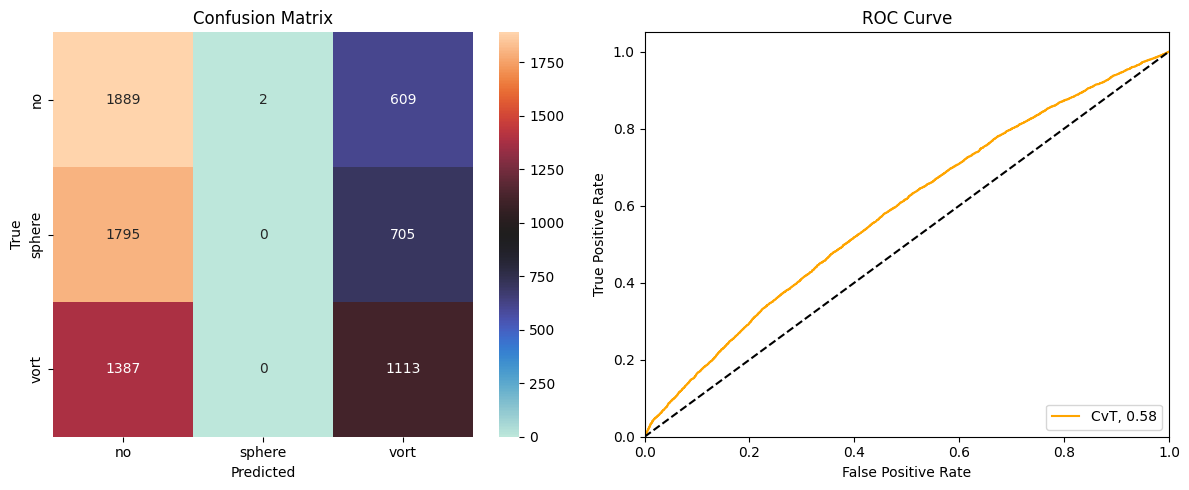

In [23]:
evaluate_model(model, criterion, 'CvT')